<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/2%20Aprendizaje%20profundo%20(I)/Sesion%203/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Lambda, Dropout
import matplotlib.pyplot as plt
from sklearn import preprocessing
tf.random.set_seed(42)

In [39]:
data_train = pd.read_csv('https://raw.githubusercontent.com/vicentcamison/idal_ia3/main/2%20Aprendizaje%20profundo%20(I)/Sesion%203/titanic_train.csv')
data_test = pd.read_csv('https://raw.githubusercontent.com/vicentcamison/idal_ia3/main/2%20Aprendizaje%20profundo%20(I)/Sesion%203/titanic_test.csv')

In [30]:
data_train

,Age,SibSp,Parch,Fare,Survived_No,Survived_Yes,Pclass_Lower,Pclass_Middle,Pclass_Upper,Sex_female,Sex_male
0,33.0,1,0,90.0000,0,1,0,0,1,1,0
1,20.0,0,0,7.8542,1,0,1,0,0,0,1
2,50.0,0,0,13.0000,1,0,0,1,0,0,1
3,18.0,2,2,262.3750,0,1,0,0,1,1,0
4,34.0,0,0,13.0000,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
706,64.0,0,0,26.0000,1,0,0,0,1,0,1
707,29.0,0,0,9.4833,1,0,1,0,0,0,1
708,19.0,0,0,10.5000,1,0,0,1,0,0,1
709,70.0,1,1,71.0000,1,0,0,0,1,0,1


#Preprocesado de datos

In [40]:
#Eliminamos algunas columnas que pensamos que no aportan ningún tipo de información
#Eliminamos la columna 'Cabin' ya que casi todas las entries son NaN

data_train = data_train.drop(['Name', 'PassengerId', 'Ticket', 'Cabin', 'Embarked'], axis=1)
data_test = data_test.drop(['Name', 'PassengerId', 'Ticket', 'Cabin', 'Embarked'], axis=1)


# ---------------
# VARIABLES DUMMY
# ---------------

data_train = pd.get_dummies(data_train, columns=['Survived', 'Pclass', 'Sex'])
data_test = pd.get_dummies(data_test, columns=['Survived', 'Pclass', 'Sex'])

#Eliminamos algunas columnas dummy innecesarias porque eran binarias
# (male = 1, female = 0;  survived = 1, not_survived = 0)
data_train.drop(['Survived_No', 'Sex_female'], axis=1, inplace=True)
data_test.drop(['Survived_No', 'Sex_female'], axis=1, inplace=True)

# Renombramos las columnas dummy binarias
data_train.rename(columns={'Survived_Yes': 'Survived', 'Sex_male': 'Sex'}, inplace=True)
data_test.rename(columns={'Survived_Yes': 'Survived', 'Sex_male': 'Sex'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 47.,  41., 146., 134.,  95.,  55.,  32.,  16.,   6.,   1.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

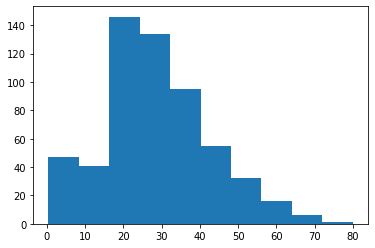

In [47]:
# -------------
# NORMALIZACIÓN
# -------------

# Comprobemos la distribución de las variables numéricas ('Age', 'Fare') con histogramas

plt.hist(data_train.loc[:, 'Age'])

(array([585.,  86.,  23.,   2.,   8.,   4.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <a list of 10 Patch objects>)

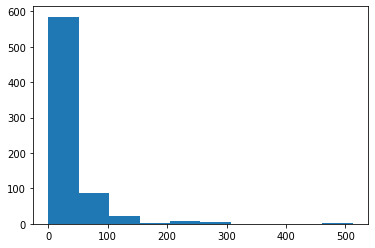

In [48]:
plt.hist(data_train.loc[:, 'Fare'])

In [52]:
# Ninguno de los datos sigue una distribución normal: usaremos la normalización MinMax

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(data_train.loc[:, ['Fare', 'Age']])

data_train.loc[:, ['Fare', 'Age']] = min_max_scaler.transform(data_train.loc[:, ['Fare', 'Age']])
data_test.loc[:, ['Fare', 'Age']] = min_max_scaler.transform(data_test.loc[:, ['Fare', 'Age']])

In [54]:
# -------------------
# SEPARACIÓN EN X E Y
# -------------------

#Separamos los datos en X e Y

X_train = data_train.drop(['Survived'], axis=1)
y_train = data_train.loc[:, 'Survived']

X_test = data_test.drop(['Survived'], axis=1)
y_test = data_test.loc[:, 'Survived']